In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from math import pi
import category_encoders as ce

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

In [2]:
data = pd.read_csv('data/player_data.csv')

In [3]:
data.head()

,player_name,unique_id,age,overall_score,height,weight,preferred_foot,best_position,player_value,weekly_wage,crossing,finishing,heading_accuracy,short_passing,volley,dribbling,curves,free_kick_accuracy,long_pass,ball_control,acceleration,sprint_speed,agility,reaction,balance,shot_power,jumping,stamina,strength,long_shot,aggression,interception,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,weak_foot,skill_moves,attacking_work_rate,defensive_work_rate,pace,shooting,passing,dribble,defense,physical
0,Neymar Jr,190871,27,92,"5'9""",150lbs,Right,LW,$119.2M,$328K,87,87,62,87,87,96,88,89,81,95,94,89,96,92,84,80,61,81,49,85,51,36,87,90,92,94,35,30,29,5 ★,5★,High,Medium,91,85,87,95,36,58
1,L. Messi,158023,32,94,"5'7""",159lbs,Left,RW,$107.9M,$633K,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,4 ★,4★,Medium,Low,87,92,92,96,39,66
2,K. Mbappé,231747,20,89,"5'10""",161lbs,Right,ST,$105.7M,$170K,78,89,75,82,81,90,79,63,70,89,96,96,92,91,83,84,76,86,76,79,62,38,90,80,70,84,34,34,32,4 ★,5★,High,Low,96,85,78,90,39,76
3,V. van Dijk,203376,27,91,"6'4""",203lbs,Right,CB,$101.7M,$271K,53,52,87,79,45,70,60,70,83,77,74,79,61,89,53,81,90,75,92,64,83,90,47,65,62,90,93,93,86,3 ★,2★,Medium,Medium,77,60,70,71,91,86
4,K. De Bruyne,192985,28,91,"5'11""",154lbs,Right,CAM,$101.7M,$418K,94,82,55,92,82,87,85,83,91,91,77,76,78,91,76,91,63,89,74,90,76,63,88,94,82,91,68,62,53,5 ★,4★,High,High,76,86,92,87,62,78


In [4]:
#convert height to centimeters
cen_in_feet = 12 # 1 foot = 12 inches
cen_in_inch = 2.54 # 1 inch = 2.54 centimeters
height_cm = []
for i in list(data['height'].str.replace("'",'').str.replace('"', '')):
    feet = int(i[0])
    inches = int(i[1:])
    
    centimeters = round((((feet * 12) + inches) * 2.54), 2)
    height_cm.append(centimeters)

data['height_cm'] = height_cm

In [5]:
#weight in kg
data['weight_kg'] = round(data.weight.str.extract('(\d+)').astype(int)/2.20462, 2)

In [6]:
def get_stats(column):
    print('mean {}'.format(column), data[column].mean())
    print('Standard Deviation {}'.format(column), data[column].std())
    sns.set()
    plt.title('{} Histogram'.format(column))
    data[column].hist(bins=10)

mean height_cm 181.17916029752993
Standard Deviation height_cm 6.780179938471034


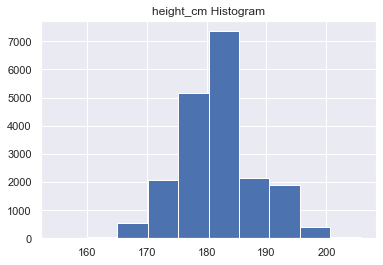

In [7]:
get_stats('height_cm')

mean weight_kg 75.09823754203985
Standard Deviation weight_kg 7.026738937344


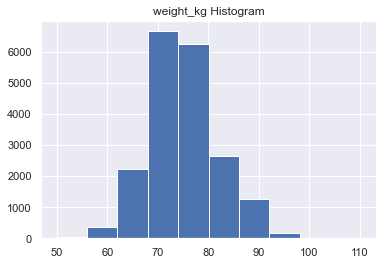

In [8]:
get_stats('weight_kg')

In [9]:
#explore player wages
wage_comp = data[['player_name','player_value','weekly_wage','best_position','age']]

In [10]:
wage_comp.head()

,player_name,player_value,weekly_wage,best_position,age
0,Neymar Jr,$119.2M,$328K,LW,27
1,L. Messi,$107.9M,$633K,RW,32
2,K. Mbappé,$105.7M,$170K,ST,20
3,V. van Dijk,$101.7M,$271K,CB,27
4,K. De Bruyne,$101.7M,$418K,CAM,28


In [11]:
#clean the currency weekly_wage values
def weekly_pay(player):
    i = player.replace('$', '')
    for p in i:
        if 'K' not in p:
            converter = i
        else:
            t_ = i.replace('K', '')
            converter = float(t_)*1e3
            
    return converter

wage_comp['weekly_salary'] = wage_comp['weekly_wage'].apply(weekly_pay)
wage_comp.weekly_salary = wage_comp.weekly_salary.astype(float)

<ipython-input-11-869d659b6a1a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wage_comp['weekly_salary'] = wage_comp['weekly_wage'].apply(weekly_pay)
/Users/drexhepi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
wage_comp.head()

,player_name,player_value,weekly_wage,best_position,age,weekly_salary
0,Neymar Jr,$119.2M,$328K,LW,27,328000.0
1,L. Messi,$107.9M,$633K,RW,32,633000.0
2,K. Mbappé,$105.7M,$170K,ST,20,170000.0
3,V. van Dijk,$101.7M,$271K,CB,27,271000.0
4,K. De Bruyne,$101.7M,$418K,CAM,28,418000.0


In [13]:
#clean the player_value
player_value = []
for i in wage_comp['player_value']:
    value = i.replace('$', '')
    if 'M' in value:
        mil = value.replace('M','')
        mil = round(float(mil)* 1e6, 2)
        player_value.append(mil)
    elif 'K' in value:
        tho = value.replace('K', '')
        tho = round(float(tho)* 1e3, 2)
        player_value.append(tho)
    else:
        zero = value
        player_value.append(zero)
        
        
wage_comp['player_market_value'] = player_value
wage_comp = wage_comp.drop(columns=['player_value','weekly_wage'])

<ipython-input-13-641f8c5ea997>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wage_comp['player_market_value'] = player_value


In [14]:
wage_comp.head()

,player_name,best_position,age,weekly_salary,player_market_value
0,Neymar Jr,LW,27,328000.0,1.192e+08
1,L. Messi,RW,32,633000.0,1.079e+08
2,K. Mbappé,ST,20,170000.0,1.057e+08
3,V. van Dijk,CB,27,271000.0,1.017e+08
4,K. De Bruyne,CAM,28,418000.0,1.017e+08


In [15]:
#whats the mean, median, min, max values for each position
#remove salary 0, a few players that dont get paid at all, these are possibly players from lower divisions 
wage_comp[wage_comp['weekly_salary']!=0].groupby('best_position')['weekly_salary'].agg(['mean','median','min','max'])

,mean,median,min,max
best_position,,,,
CAM,10875.814880,3000.0,565.0,418000.0
CB,9634.019419,3000.0,565.0,339000.0
CDM,10418.842177,3000.0,565.0,316000.0
CF,40340.509615,8000.0,565.0,418000.0
CM,15055.560748,4000.0,565.0,384000.0
GK,7026.759131,2000.0,565.0,283000.0
LB,8064.940522,3000.0,565.0,249000.0
LM,8813.889189,3000.0,565.0,198000.0
LW,17913.417112,4000.0,565.0,531000.0


In [16]:
#who is the ST getting paid the most  [Cristiano Ronaldo]
wage_comp.query('best_position=="ST" & weekly_salary>450000')

,player_name,best_position,age,weekly_salary,player_market_value
25,Cristiano Ronaldo,ST,34,463000.0,6.61e+07


In [17]:
#who is the LW getting paid the most [E.Hazard]
wage_comp.query('best_position=="LW" & weekly_salary>530000')

,player_name,best_position,age,weekly_salary,player_market_value
5,E. Hazard,LW,28,531000.0,1.017e+08


In [18]:
#who is the RW getting paid the most [L. Messi]
wage_comp.query('best_position=="RW" & weekly_salary>600000')

,player_name,best_position,age,weekly_salary,player_market_value
1,L. Messi,RW,32,633000.0,1.079e+08


In [19]:
wage_comp.player_market_value = wage_comp.player_market_value.astype(int)

In [20]:
wage_comp.describe()

,age,weekly_salary,player_market_value
count,19626.000000,19626.000000,1.962600e+04
mean,24.767604,9800.188959,2.727925e+06
std,4.687726,22964.514254,6.186951e+06
min,16.000000,0.000000,0.000000e+00
25%,21.000000,1000.000000,3.670000e+05
50%,24.000000,3000.000000,7.910000e+05
75%,28.000000,8000.000000,2.300000e+06
max,47.000000,633000.000000,1.192000e+08


In [21]:
wage_comp_distribution = wage_comp.query('weekly_salary!=0 & player_market_value !=0').groupby('best_position').\
    agg({'weekly_salary':['mean','median','min','max'],
         'player_market_value': ['mean','median','min','max']})

wage_comp_distribution

weekly_salary                          player_market_value  \
                       mean  median    min       max                mean   
best_position                                                              
CAM            10875.814880  3000.0  565.0  418000.0        3.722132e+06   
CB              9633.200291  3000.0  565.0  339000.0        2.509033e+06   
CDM            10425.253914  3000.0  565.0  316000.0        2.901556e+06   
CF             40340.509615  8000.0  565.0  418000.0        9.225096e+06   
CM             15055.560748  4000.0  565.0  384000.0        4.191287e+06   
GK              7026.759131  2000.0  565.0  283000.0        1.940851e+06   
LB              8064.940522  3000.0  565.0  249000.0        1.840630e+06   
LM              8813.889189  3000.0  565.0  198000.0        2.545189e+06   
LW             17913.417112  4000.0  565.0  531000.0        5.682139e+06   
LWB             8998.149819  3000.0  565.0  153000.0        2.700188e+06   
RB              8968.837876  3000.0  565.0  226000.0        1.950213e+06   
RM              7159.855821  2000.0  565.0  147000.0        2.052190e+06   
RW             18493.259690  4000.0  565.0  633000.0        4.556190e+06   
RWB             8800.804422  3000.0  565.0  164000.0        2.469418e+06   
ST             10664.459269  4000.0  565.0  463000.0        2.964791e+06   

                                           
                median     min        max  
best_position                              
CAM             989000   51000  101700000  
CB              763000   23000  101700000  
CDM             904000   28000   68900000  
CF             2850000  136000   78000000  
CM             1100000   28000   72300000  
GK              452000    3000   87600000  
LB              650000   51000   39600000  
LM              876000   68000   61000000  
LW             1100000   90000  119200000  
LWB             876000   68000   55400000  
RB              706000   34000   39000000  
RM              763000   34000   53700000  
RW             1100000   57000  107900000  
RWB             876000   90000   52000000  
ST              904000   34000  105700000

In [22]:
#drop multi-index
wage_comp_distribution.columns = ['_'.join(col) for col in wage_comp_distribution.columns]

In [23]:
wage_comp_distribution

,weekly_salary_mean,weekly_salary_median,weekly_salary_min,weekly_salary_max,player_market_value_mean,player_market_value_median,player_market_value_min,player_market_value_max
best_position,,,,,,,,
CAM,10875.814880,3000.0,565.0,418000.0,3.722132e+06,989000,51000,101700000
CB,9633.200291,3000.0,565.0,339000.0,2.509033e+06,763000,23000,101700000
CDM,10425.253914,3000.0,565.0,316000.0,2.901556e+06,904000,28000,68900000
CF,40340.509615,8000.0,565.0,418000.0,9.225096e+06,2850000,136000,78000000
CM,15055.560748,4000.0,565.0,384000.0,4.191287e+06,1100000,28000,72300000
GK,7026.759131,2000.0,565.0,283000.0,1.940851e+06,452000,3000,87600000
LB,8064.940522,3000.0,565.0,249000.0,1.840630e+06,650000,51000,39600000
LM,8813.889189,3000.0,565.0,198000.0,2.545189e+06,876000,68000,61000000
LW,17913.417112,4000.0,565.0,531000.0,5.682139e+06,1100000,90000,119200000


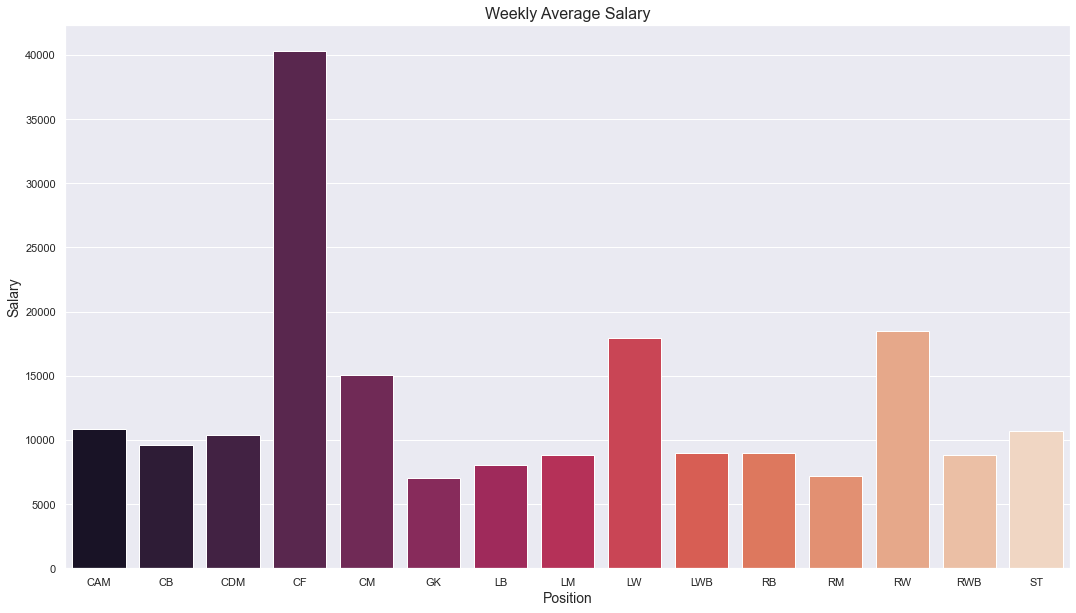

In [24]:
plt.figure(figsize=(18,10))
ax = sns.barplot(x=wage_comp_distribution.index, y=wage_comp_distribution.weekly_salary_mean,
                palette = 'rocket')

plt.title('Weekly Average Salary', size=16)
plt.ylabel('Salary', size = 14)
plt.xlabel('Position', size=14);
#CF have the highest weekly salary on average

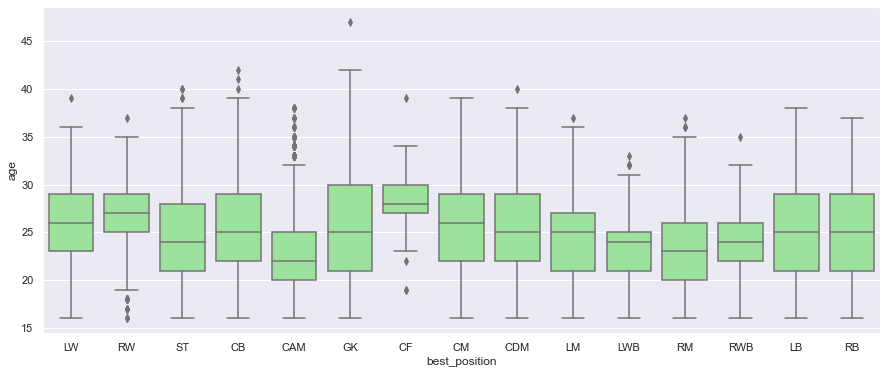

In [25]:
plt.figure(figsize=(15,6))
sns.boxplot(x=wage_comp['best_position'], y = wage_comp['age'], color = 'lightgreen');
#looks like the majority of the oldest players are in the CF position. 
#GK appear to have to highest spread

/Users/drexhepi/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


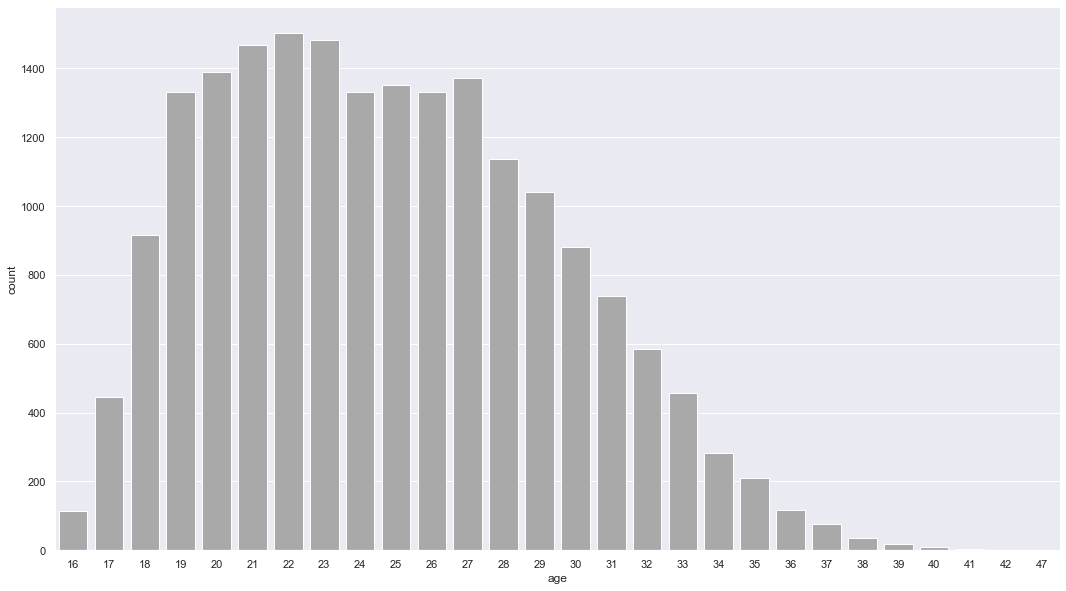

In [26]:
plt.figure(figsize=(18,10))
sns.countplot('age',data=wage_comp, color='darkgray');
#the data is right skewed, which makes sense, a lot of the players are in the mid-20s. That is usualy when you 
#are in your price. And depeding on the position you play on the field, many players can't player longer than the 
#age or 32-35 due to the nature of the sport and high physical demands of the game 

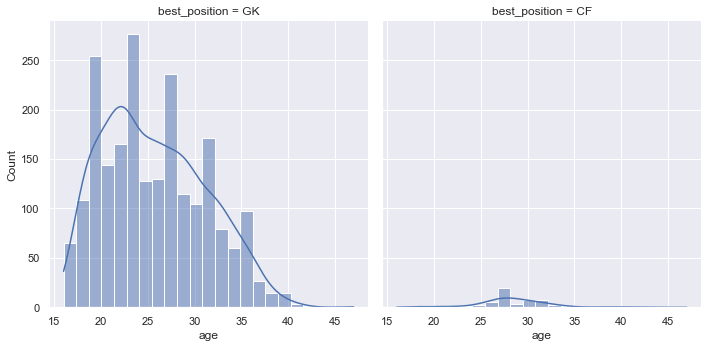

In [27]:
#I know GK and CF tend of have an order average age
sns.displot(data=wage_comp.query('best_position=="CF" | best_position=="GK"'), x='age',col='best_position',
           kde=True);

### Radar Charts

In [28]:
player_sample = data[(data['player_name']=='Neymar Jr') | (data['player_name']=='L. Messi') | 
                    (data['player_name']=='K. Mbappé') | (data['player_name']=='K. De Bruyne') |
                    (data['player_name']=='Cristiano Ronaldo')].set_index('player_name')

In [29]:
player_sample = player_sample[['defense','dribble','pace','passing','physical','shooting']]

In [30]:
player_sample

,defense,dribble,pace,passing,physical,shooting
player_name,,,,,,
Neymar Jr,36,95,91,87,58,85
L. Messi,39,96,87,92,66,92
K. Mbappé,39,90,96,78,76,85
K. De Bruyne,62,87,76,92,78,86
Cristiano Ronaldo,35,89,90,82,78,93


In [201]:
# #columns in a list
# attributes = list(player_sample)

# #len of attributes
# length = len(attributes)

In [200]:
# #sample the first player
# #take a list of the values that we want to plot, copy the first value to the end. when we plot the data,
# # this will be the line that the radar follows 
# values = player_sample.iloc[0].tolist()
# values += values[:1]
# values

In [199]:
# angles = [n/float(length) *2 * pi for n in range(lenght)]
# angles += angles[:1]

In [198]:
# #now we have our values to plot and the angles between them, drawing the radar is pretty simple
# #NOTE 'polar=true' in our subplot - this changes our chart from a more-traditional x and y axes chart, to a more
# #circular radar chart that we are looking for. 

# plt.figure(figsize=(16,8))

# ax = plt.subplot(111, polar=True)

# #add the attributes labels to our axes
# plt.xticks(angles[:-1], attributes, size=15)

# #plot the line around the outside of hte filled area, using the angles and values calculated before
# ax.plot(angles, values)

# #fill in the area plotted in the last line
# ax.fill(angles, values, 'teal', alpha=0.1)

# #give te plot a title and show it
# plt.figtext(0.2, 0.9, 'Neymar', color='teal', size = 20)
# ax.tick_params(axis='both', which = 'major', pad=25)
# plt.show();

In [71]:
# values2 = player_sample.iloc[3].tolist()
# values2 += values2[:1]
# angles2 = [n / float(length) * 2 * pi for n in range(length)]
# angles2 += angles2[:1]

In [84]:
# #create a function that compares two players
# def createRadar(player1, data1, player2, data2):
#     plt.figure(figsize=(16,8))
#     attributes = player_sample.columns.tolist()
    
#     data1 += data1[:1]
#     data2 += data2[:1]
    
#     angles = [(((n/6)*2)*pi) for n in range(6)]
#     angles += angles[:1]
    
#     angles2 = [(((n/6)*2)*pi) for n in range(6)]
#     angles2 += angles2[:1]
    
#     #creat the chart 
#     ax = plt.subplot(111, polar = True)
    
#     plt.xticks(angles[:-1], attributes)
    
#     ax.plot(angles, values)
#     ax.fill(angles, values,alpha=0.1)
    
#     ax.plot(angles2, values2)
#     ax.fill(angles2, values2, alpha=0.05)
    
    
#     #rather than use a title, individual text points are added
#     plt.figtext(0.2,0.9, player1, color='blue')
#     plt.figtext(0.2, 0.85, 'v')
#     plt.figtext(0.2, 0.8, player2, color='darkorange')
    
#     ax.tick_params(axis='both', which='major',pad=25)#pushes the text away from circle

In [197]:
# createRadar(player_sample.index[1], player_sample.iloc[1].tolist(),
#           player_sample.index[4], player_sample.iloc[4].tolist())

In [31]:
from ipywidgets import interact

In [33]:
@interact
def player_radar(player1 = player_sample.index.unique().tolist(),
                 player2 = player_sample.index.unique().tolist()[::-1]):
    
    plt.figure(figsize=(18,12))
    
    features = list(player_sample)
    size = len(features)
    
    player1_values = player_sample.loc[player1].tolist()
    player1_values += player1_values[:1]
    
    player2_values = player_sample.loc[player2].tolist()
    player2_values += player2_values[:1]
    
    angles1 = [(((n/6) *2) *pi) for n in range(6)]
    angles1 += angles1[:1]
    
    angles2 = [(((n/6) *2) *pi) for n in range(6)]
    angles2 += angles2[:1]
    
    #create the chart 
    ax = plt.subplot(111, polar = True)
    
    plt.xticks(angles1[:-1], features, size=20)
    
    #player 1
    ax.plot(angles1, player1_values)
    ax.fill(angles1,player1_values, alpha=0.1)
    
    #player 2 
    ax.plot(angles2, player2_values)
    ax.fill(angles2, player2_values, alpha=0.05)
    
    #push the text away from the circle
    ax.tick_params(axis='both', which = 'major', pad = 25)
    
    #title
    #plt.title('{0} vs. {1}'.format(player1, player2),size=20,pad=25)
    plt.figtext(0.45,0.96, player1, color='blue', size=15, ha = 'right',fontweight='bold')
    plt.figtext(0.48,0.96, 'vs', size = 15, color='k', ha = 'center',fontweight='bold')
    plt.figtext(0.51, 0.96, player2, color='orange', size=15, ha = 'left',fontweight='bold')
    
    plt.show()
    

interactive(children=(Dropdown(description='player1', options=('Neymar Jr', 'L. Messi', 'K. Mbappé', 'K. De Br…

In [34]:
levels = {'attacking_work_rate':{'Low':1, 'Medium':2, 'High':3},
          'defensive_work_rate': {'Low':1, 'Medium':2, 'High':3}}

data = data.replace(levels)

In [35]:
data['weak_foot'] = [int(x[0]) for x in data.weak_foot.str.split(' ')]
data['skill_moves'] = data.skill_moves.str.extract('(\d+)').astype(int)
data = data.drop(columns = ['unique_id','age','height','weight','player_value','weekly_wage'])

In [37]:
data.best_position.unique()

array(['LW', 'RW', 'ST', 'CB', 'CAM', 'GK', 'CF', 'CM', 'CDM', 'LM',
       'LWB', 'RM', 'RWB', 'LB', 'RB'], dtype=object)

In [38]:
data = pd.get_dummies(data, columns = ['preferred_foot'], drop_first = True)

In [40]:
encoder = ce.BinaryEncoder(cols=['best_position'])
data = encoder.fit_transform(data)

In [41]:
data.head()

,player_name,overall_score,best_position_0,best_position_1,best_position_2,best_position_3,best_position_4,crossing,finishing,heading_accuracy,short_passing,volley,dribbling,curves,free_kick_accuracy,long_pass,ball_control,acceleration,sprint_speed,agility,reaction,balance,shot_power,jumping,stamina,strength,long_shot,aggression,interception,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,weak_foot,skill_moves,attacking_work_rate,defensive_work_rate,pace,shooting,passing,dribble,defense,physical,height_cm,weight_kg,preferred_foot_Right
0,Neymar Jr,92,0,0,0,0,1,87,87,62,87,87,96,88,89,81,95,94,89,96,92,84,80,61,81,49,85,51,36,87,90,92,94,35,30,29,5,5,3,2,91,85,87,95,36,58,175.26,68.04,1
1,L. Messi,94,0,0,0,1,0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,4,4,2,1,87,92,92,96,39,66,170.18,72.12,0
2,K. Mbappé,89,0,0,0,1,1,78,89,75,82,81,90,79,63,70,89,96,96,92,91,83,84,76,86,76,79,62,38,90,80,70,84,34,34,32,4,5,3,1,96,85,78,90,39,76,177.80,73.03,1
3,V. van Dijk,91,0,0,1,0,0,53,52,87,79,45,70,60,70,83,77,74,79,61,89,53,81,90,75,92,64,83,90,47,65,62,90,93,93,86,3,2,2,2,77,60,70,71,91,86,193.04,92.08,1
4,K. De Bruyne,91,0,0,1,0,1,94,82,55,92,82,87,85,83,91,91,77,76,78,91,76,91,63,89,74,90,76,63,88,94,82,91,68,62,53,5,4,3,3,76,86,92,87,62,78,180.34,69.85,1


# MODELS


### Dimensionality Reduction
Reducing dimensionality **does cause** some information loss (just like compressing an image to JPEG can degrade its quality), so even though it will speed up training, it may make your system perform slightly worse. It also makes your pipelines a bit more complex and thus harder to maintain. 

### The Curse of Dimensionality 
if you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly 0.52. If you pick two random points in a unit 3D cube, the average distance will be roughly 0.66. But what about two points picked randomly in s 1,000,000-dimensional hypercube? The average distance will be about 408.25. This is counterintuitive: how can two points be so far apart when they both lie within the same unit hypercube? because there's just plenty of space in high dimensions. 

As a result, high-dimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other, making predictions mucn less reliable than in lower dimensions, since they will be based on much larger extrapolations. In short, the more dimensions the training set has, the greater the risk of overfitting it.

### Manifold Learning
relies on the manifold assumption **(manifold hypothesis)**, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. 

reducing the dimensionality of your training set before training a model will usually speed up trainng, but it may not always lead to a better or simpler solution; it all depetds on the dataset.

## PCA

preserving variance. select the axis that preserves the maximum amount of variance, as it will most likely lose less information that the other projections. i.e., the axis that minimizes the **mean squared distance** between the original and its projection onto that axis. 

In [43]:
features = data[data.columns[1:]].columns

In [44]:
data_scaled = data[data.columns[1:]].loc[:,features].values
data_scaled = StandardScaler().fit_transform(data_scaled)

In [45]:
np.mean(data_scaled), np.std(data_scaled)

(4.018661146915883e-17, 0.9895285072531598)

In [47]:
#Linear dimensionaltiy reduction using Singular Value Decomposition of the data to project it to a lower 
#dimensional space. The input data is centered but not scaled for each feature before applying SVD

#using sklearn PCA automatically take care of centering the data
pca_1 = PCA(n_components = 2)
pca_1_data = pca_1.fit_transform(data_scaled)

In [48]:
pca_1_data.shape

(19626, 2)

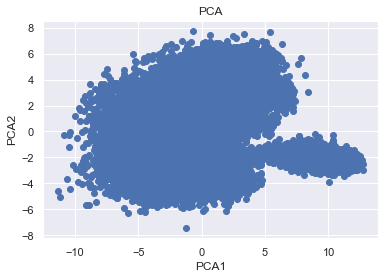

In [49]:
plt.scatter(pca_1_data[:,0], pca_1_data[:,1])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA');

#### Feature Importance

In [50]:
# Feature Importance

#the importance of each feature is reflected by the magnitude of the corresponding values in the 
#eigenvectors (higher magnitude - higher importance).
pca_1.components_

array([[-1.28072536e-01,  3.48726972e-22, -8.97623993e-02,
         8.39056718e-02,  5.70465101e-02, -8.46757003e-02,
        -2.06692314e-01, -1.91275989e-01, -1.41301556e-01,
        -2.11423619e-01, -1.95314146e-01, -2.18460727e-01,
        -2.08343655e-01, -1.93618004e-01, -1.91856118e-01,
        -2.19533618e-01, -1.71748189e-01, -1.67909949e-01,
        -1.82636626e-01, -1.28941331e-01, -1.57646984e-01,
        -1.64921944e-01, -5.64149699e-02, -1.80674591e-01,
        -2.33909405e-02, -2.07040054e-01, -1.35035835e-01,
        -1.00763684e-01, -2.08919634e-01, -1.85672104e-01,
        -1.86135366e-01, -1.79496052e-01, -1.07109676e-01,
        -9.83937261e-02, -9.07748018e-02, -9.28942489e-02,
        -1.91456651e-01, -8.73322563e-02, -7.22308025e-03,
        -9.16803871e-02, -7.82043740e-02, -1.17167591e-01,
        -1.21079054e-01, -5.85466272e-02, -4.35773554e-02,
         1.07531762e-01,  8.37169457e-02,  2.87334520e-02],
       [ 5.59877285e-02,  1.97156947e-19,  3.55437598e-

In [51]:
#the larger these absolute values are, the more a specific feature contributes to that principal component.
print(abs(pca_1.components_))

[[1.28072536e-01 3.48726972e-22 8.97623993e-02 8.39056718e-02
  5.70465101e-02 8.46757003e-02 2.06692314e-01 1.91275989e-01
  1.41301556e-01 2.11423619e-01 1.95314146e-01 2.18460727e-01
  2.08343655e-01 1.93618004e-01 1.91856118e-01 2.19533618e-01
  1.71748189e-01 1.67909949e-01 1.82636626e-01 1.28941331e-01
  1.57646984e-01 1.64921944e-01 5.64149699e-02 1.80674591e-01
  2.33909405e-02 2.07040054e-01 1.35035835e-01 1.00763684e-01
  2.08919634e-01 1.85672104e-01 1.86135366e-01 1.79496052e-01
  1.07109676e-01 9.83937261e-02 9.07748018e-02 9.28942489e-02
  1.91456651e-01 8.73322563e-02 7.22308025e-03 9.16803871e-02
  7.82043740e-02 1.17167591e-01 1.21079054e-01 5.85466272e-02
  4.35773554e-02 1.07531762e-01 8.37169457e-02 2.87334520e-02]
 [5.59877285e-02 1.97156947e-19 3.55437598e-02 9.14648949e-02
  1.58720048e-01 9.89416792e-02 5.94162241e-03 1.31387250e-01
  1.68188607e-01 7.80044548e-02 9.56088173e-02 3.63761732e-02
  4.75884453e-02 3.24606453e-02 1.01048059e-01 2.13477921e-02
  7.143

In [54]:
feature_importance = pd.DataFrame(data = abs(pca_1.components_), columns = features, index=['PCA1','PCA2'])
feature_importance = feature_importance.T

In [56]:
#top 10 most important features that influence PCA1
feature_importance[['PCA1']].sort_values('PCA1', ascending = False).head(10)

,PCA1
ball_control,0.219534
dribbling,0.218461
short_passing,0.211424
positioning,0.208920
curves,0.208344
long_shot,0.207040
crossing,0.206692
volley,0.195314
free_kick_accuracy,0.193618
long_pass,0.191856


In [57]:
feature_importance[['PCA2']].sort_values('PCA2', ascending=False).head(10)

,PCA2
defense,0.319582
sliding_tackle,0.302673
standing_tackle,0.302549
interception,0.300527
marking,0.292146
aggression,0.234581
shooting,0.229143
physical,0.215963
strength,0.199983
defensive_work_rate,0.172724


<Figure size 1440x8640 with 0 Axes>

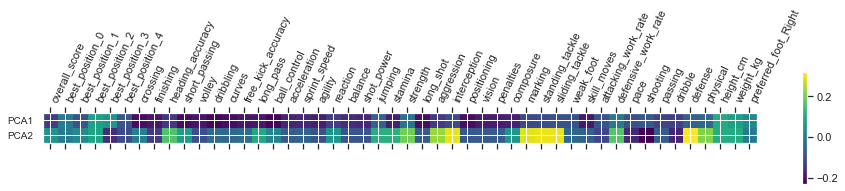

In [60]:
plt.figure(figsize=(20,120))
plt.matshow(pca_1.components_, cmap='viridis')
plt.yticks([0,1],['PCA1','PCA2'], fontsize=10)
plt.colorbar()
plt.xticks(range(len(features)), features, rotation= 65, ha ='left');

In [62]:
pca_1.explained_variance_ratio_
#the first dimension explains 39.2% of the variance, while the second explains 16.3%

array([0.39207718, 0.16265066])

In [63]:
# By projecting down to 2D, we lost about 44.5% of the variance
1 - pca_1.explained_variance_ratio_.sum()

0.4452721630943113

In [64]:
pca_1_data_variance = pd.DataFrame(data = pca_1_data, columns = ['PC1','PC2'])
pca_1_data_variance.head()

,PC1,PC2
0,-11.193004,-5.062195
1,-11.281362,-4.562526
2,-9.746799,-3.931986
3,-5.435370,5.939491
4,-10.862031,-0.266667


## Choosing the Right Number of Dimensions
instead of arbitrarily choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%)

In [65]:
pca_95p = PCA()
pca_95p.fit(data_scaled)
cumsum = np.cumsum(pca_95p.explained_variance_ratio_)

In [66]:
d = np.argmax(cumsum>= 0.95) + 1
d

23

Text(30, 0.8, 'Elbow')

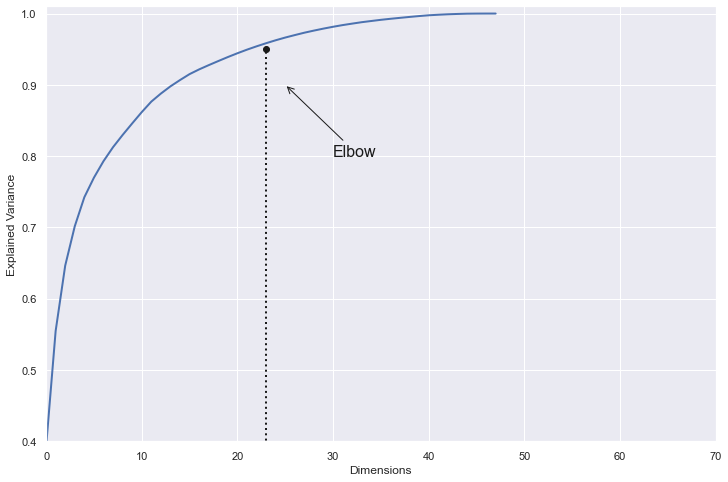

In [77]:
plt.figure(figsize = (12,8))
plt.plot(cumsum, linewidth=2)
plt.axis([0, 70, 0.4, 1.01])
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.plot([d,d], [0, 0.95], 'k:', linewidth=2)
plt.plot(d, 0.95, 'ko')
plt.annotate('Elbow', xy=(25, 0.9), xytext = (30, 0.8), arrowprops = dict(arrowstyle='->',color='k'),
            fontsize=16, c='k',)


In [78]:
# you could then set n_components = d and run PCA again. But there is a much better option: instead of specifying
#the number of PC you want to preserve, you can set n_components to be a float between 0 and 1, indicating the 
#ratio of variance you wish to preserve
pca_sample = PCA(n_components = 0.95)
pca_sample_ = pca_sample.fit_transform(data_scaled)

In [79]:
pca_sample.explained_variance_ratio_

array([0.39207718, 0.16265066, 0.09171349, 0.05520692, 0.0406933 ,
       0.02739905, 0.02314107, 0.01968427, 0.01708954, 0.01620906,
       0.01585697, 0.01474224, 0.01127332, 0.01013217, 0.00883393,
       0.00833572, 0.00662013, 0.00595656, 0.0057367 , 0.00561758,
       0.00532883, 0.00504091, 0.00465891])

In [80]:
pca_sample.n_components_

23

In [81]:
np.sum(pca_sample.explained_variance_ratio_)

0.9539984927909528

# K-Means model
Note: The K-Means algorithm does not behave very well when the blobs have very **different diameters** because all it cares about when assigning an instance to a cluster is the distance to the centroid.

- **Hard Clustering** - assigns each instance to a single cluster
- **Soft Clustering** - give each instance a score per cluster. The score can be the distance between the instance and the centroid i.e., similarity score (or affinity)

Since K-Means is a **distance based** algorithm, the difference of magnitude can create a problem so we nned to first standardize all the variables

### Centroid Initialization method
Although the algorithm is guaranteed to converege, it may not converge to the right solution(i.e., it may converge to a local optimum): whether it does or not depends on the centroid initialization.

how to know which one is best? **Ineria** the K-Means runs the algorithm n_init times and keeps the model with the **lowest Inertia**

Note: as the number of clusters [k] increases, the inertia gets smaller and smaller. The model picks the Lowest inertia. Use the elbow method

## Finding the optimal number of clusters
#### Elbow Method*

- can we just pick the model with the lowest inertia? Unfortunately, it's not that simple. The inertial is not a good performance metric when trying to choose K because it keeps getting lower as we increase K. The more cluster there are, the closer each instance will be to its closest centroid, and therefore the lower the inerta will be. 
- plotting the inertia as a function of the number of clusters k, the curve often contains an inflextion point called the ``elbow``


______________________


#### Silhouette Score
- Another approach (more computationally expensive) is to use the silhouette score, which is the **mean silhouette coefficient** over all the instances. The silhouette coefficient can vary betwen **-1 and +1**. A coefficient close to a +1 means that the instance is well inside its own cluster and far from the other clusters, while a coefficient close to 0 means that it is closer to a cluster boundary, and finally a coefficient close to -1 means that te instance may have been assigned to the wrong cluster. 

_____________________

### Silhouette Diagram
- plot every instance's silhouette coeficient, sorted by the cluster they are assigned to and by the value of the coefficient. In this, each diagram contains on knife shape per cluster. The shape's height indicates the number of instances the cluster contains, and the width represents the sorted solhouette coefficients of the instances in the cluster (wider is better).

## Limits to K-Means
- it is necessary to run the algorithm several times to avoid suboptimal solutions
- you need to specify the number of clusters, which can be quite a hassle
- K-Means does not behave very well when the clusters have **varying sizes, different densities, and nonspherical shapes**
- Different clustering algorithms may perform better, depeding on the data
- i.e., Gaussian Mixture models work great on elliptical clusters data

In [85]:
kmeans_model = [KMeans(n_clusters = k, random_state = 42).fit(pca_sample_) for k in range (1,21)]
inertia = [model.inertia_ for model in kmeans_model]

In [86]:
inertia

[879989.1977172162,
 643063.4349962485,
 513978.26650416414,
 443884.34336300666,
 405830.7805261569,
 375567.83302046295,
 356774.0686879028,
 342003.824563203,
 330010.94623346877,
 319215.80018105876,
 309259.2868160819,
 302405.17799982347,
 293835.56101324776,
 287638.3449226026,
 282247.3486333485,
 278087.31247237354,
 273687.0192562161,
 269418.8803230162,
 265515.2416487236,
 262413.8323304968]

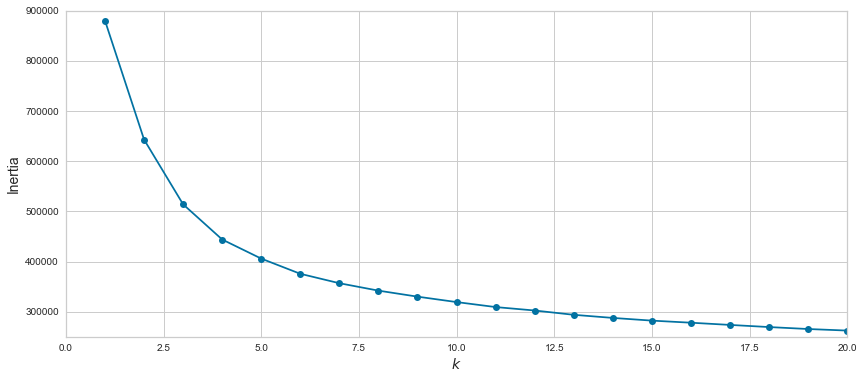

In [91]:
plt.figure(figsize = (14,6))
plt.plot(range(1,21), inertia, 'bo-')
plt.xlabel('$k$', fontsize=14)
plt.ylabel('Inertia',fontsize=14)
plt.axis([0, 20, 250000, 900000]);

In [93]:
silhouette_scores = [silhouette_score(pca_sample_, model.labels_) for model in kmeans_model[1:]]

In [94]:
silhouette_scores

[0.2686227603244299,
 0.23189883458195015,
 0.223172565748155,
 0.20940609710574254,
 0.21270237752603652,
 0.1984354315988129,
 0.1875678236370402,
 0.17745611376398276,
 0.17515661377958977,
 0.14644456876796608,
 0.14573858441827856,
 0.14456754199232386,
 0.14769811278214798,
 0.14244421691599063,
 0.1405324151233719,
 0.13989814827517394,
 0.13871081182409806,
 0.13726210942271083,
 0.13606639286071648]

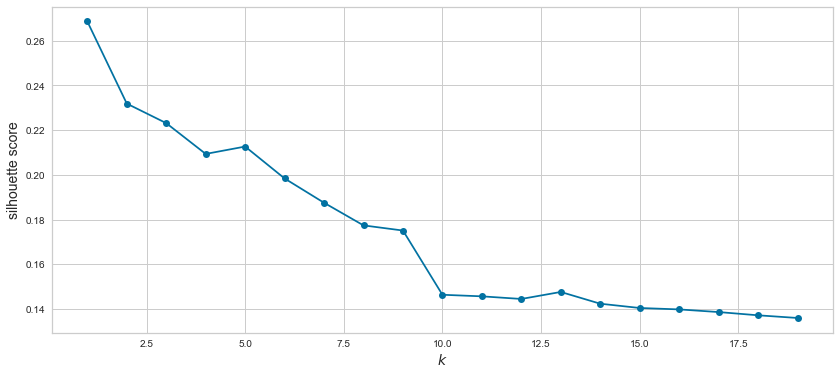

In [97]:
plt.figure(figsize = (14,6))
plt.plot(range(1,20), silhouette_scores, 'bo-')
plt.xlabel('$k$', fontsize=14)
plt.ylabel('silhouette score', fontsize=14);

### Using a package we can do the elbow and silhouette graphs a lot easier than the manual way from above

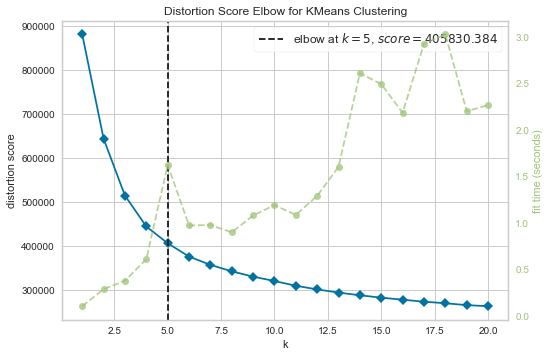

In [99]:
#Elbow Method
kelbow_visualizer(KMeans(), pca_sample_, k=(1,21));

/Users/drexhepi/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/drexhepi/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/drexhepi/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


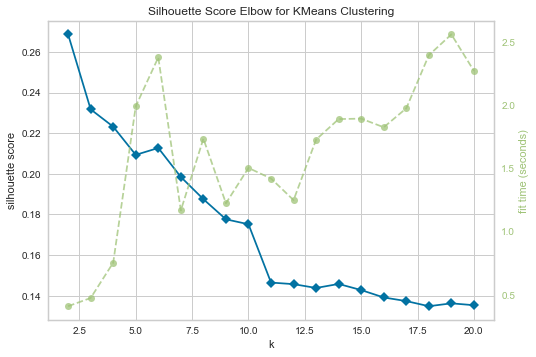

In [100]:
#Silhouette method
kelbow_visualizer(KMeans(), pca_sample_, k=(2,21), metric='silhouette');

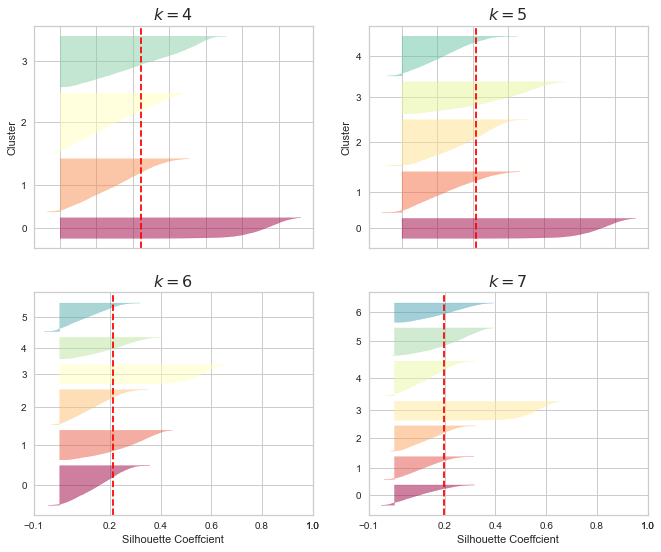

In [116]:
plt.figure(figsize=(11,9))

for k in (4,5,6,7):
    plt.subplot(2, 2, k-3)
    
    y_pred = kmeans_model[k-1].labels_
    silhouette_coefficients = silhouette_samples(pca_sample_, y_pred)
    
    padding = len(pca_sample_)//30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred ==i]
        coeffs.sort()
        
        color = mpl.cm.Spectral(i/k)
        plt.fill_betweenx(np.arange(pos,pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color,
                          alpha=0.5)
        
        ticks.append(pos + len(coeffs)//2)
        pos += len(coeffs) + padding
    
    
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (4,5):
        plt.ylabel('Cluster')
        
    if k in (6,7):
        plt.gca().set_xticks([-0.1, 1, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel('Silhouette Coeffcient')
    else:
        plt.tick_params(labelbottom = False)
        
    plt.axvline(x=silhouette_scores[k-2], color='red', linestyle='--')
    plt.title("$k={}$".format(k), fontsize=16)
